In [43]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms

from src.utils.data_utils import TGIF
from src.utils.trainer import ModelTrainer

from src.models.vae import VAE, Initializer

import numpy as np
import os

%load_ext autoreload
%autoreload 2


TEST_MODEL_PATH = os.path.join(os.getcwd(), 'src', 'experiments', 'vae')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
def flatten(x):
    N = x.shape[0]
    return x.view(N, -1)

def lstm_flatten(x):
    B, T = x.shape[0], x.shape[1]
    return x.view(B, T, -1)

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

In [45]:
def deprocess(img):
    transform = transforms.Compose([
        transforms.Lambda(rescale),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled


In [46]:
USE_GPU = True

dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using device:', device)
print('Using type:', dtype)

Using device: cuda
Using type: torch.float32


In [47]:
IMAGE_SZ = (64, 64)
BATCH_SZ = 64
NUM_WORKERS = 4
MAX_FRAMES = 10

# DATASET_ROOT = '/home/deepdeepfakes/cs231n-project/src/datasets/TGIF/GIFs/'
DATASET_ROOT = '/home/deepdeepfakes/cs231n-project/src/datasets/GGIF/GIFs/nature/'

train_set = TGIF(
    root=f'{DATASET_ROOT}/train',
#     root='/home/deepdeepfakes/cs231n-project/src/datasets/GGIF/GIFs/nature/train',    
    preload=False,                    # careful: will load all into memory
    max_frames=MAX_FRAMES,
    transform=transforms.Compose([
        transforms.Resize(IMAGE_SZ), # standardize size
        transforms.ToTensor(),       # conver to tensor between 0...1
                                     # TODO: subtract mean 
                                     # have fixed frame size somehow
    ]),
)

val_set = TGIF(
    root=f'{DATASET_ROOT}/val',
#     root='/home/deepdeepfakes/cs231n-project/src/datasets/GGIF/GIFs/nature/val',
    preload=False,                    # careful: will load all into memory
    max_frames=MAX_FRAMES,
    transform=transforms.Compose([
        transforms.Resize(IMAGE_SZ), # standardize size
        transforms.ToTensor(),       # conver to tensor between 0...1
                                     # TODO: subtract mean 
                                     # have fixed frame size somehow
    ]),
)

test_set = TGIF(
    root=f'{DATASET_ROOT}/test',
#     root='/home/deepdeepfakes/cs231n-project/src/datasets/GGIF/GIFs/nature/test',
    preload=False,                    # careful: will load all into memory
    max_frames=MAX_FRAMES,
    transform=transforms.Compose([
        transforms.Resize(IMAGE_SZ), # standardize size
        transforms.ToTensor(),       # conver to tensor between 0...1
                                     # TODO: subtract mean 
                                     # have fixed frame size somehow
    ]),
)



In [48]:
overfit_train_set = DataLoader(train_set, 
                               batch_size=BATCH_SZ, 
                               num_workers=NUM_WORKERS, 
                               drop_last=True,
                               sampler=sampler.SubsetRandomSampler([i for i in range(150, 150 + BATCH_SZ)]))


train_loader = DataLoader(train_set, batch_size=BATCH_SZ, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_set, batch_size=BATCH_SZ, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)

print(len(train_set), len(val_set), len(test_set))

3995 750 250


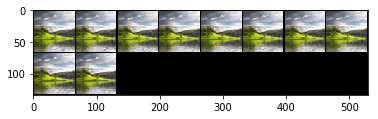

Process Process-7260:
Process Process-7257:
Process Process-7259:
Process Process-7258:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/shared/anaconda3/lib/python3.6/sit

In [49]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(train_loader)
gif = dataiter.next()[0]

def imshow(img, save_file=None):
    npimg = img.numpy()
    out = np.transpose(npimg, (1, 2, 0))

    if save_file:
        plt.imsave(save_file, out)
        
    plt.imshow(out)
    
imshow(torchvision.utils.make_grid(gif))

# indx = 0
# try:
#     for i in range(3668, len(train_set)):
#         if i % 200 == 0:
#             print(i)
#         indx = i
#         x = train_set[i]

# except ValueError:
#     print(indx, train_set.filenames[indx])

    


In [50]:


def train_fn(model, optimizer, inp):
    
    def loss_fn(recon_x, x, mu, logvar):
        
        def mse_loss(inp, target):
            return torch.sum((inp - target) ** 2) / inp.shape[0]
            
#         mse_loss = nn.MSELoss(size_average=False)
#         test2 = nn.MSELoss(size_average=False)(recon_x, x)

        MSE = mse_loss(recon_x, x)
        

        # see Appendix B from VAE paper:    https://arxiv.org/abs/1312.6114
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - torch.exp(logvar))
        return MSE + KLD
    

    
    model.train()         
    
#     x = inp[0] # TODO remove
    
    
    x = inp[:, 0, :, :, :]

    x = x.to(device=device, dtype=dtype)

    recon_x, mu, logvar = model(x)
    
#     print('---', x.shape, recon_x.shape)

    loss = loss_fn(recon_x, x, mu, logvar)

    loss.cuda().backward()
    optimizer.step()
    
    optimizer.zero_grad()
    
    return loss.item()

## Train network

In [53]:
NUM_CHANNELS = 3
INPUT_SIZE = IMAGE_SZ[0] * IMAGE_SZ[1] * NUM_CHANNELS   
HIDDEN_SIZE = INPUT_SIZE
OUTPUT_SIZE = INPUT_SIZE


net = VAE(latent_size=100, device=device)
Initializer.initialize(model=net, initialization=init.xavier_uniform_, gain=init.calculate_gain('relu'))

# optimizer = optim.SGD(net.parameters(), lr=1e-6, momentum=0.9, nesterov=True)
optimizer = optim.Adam(net.parameters(), lr=2e-4)

trainer = ModelTrainer(net, optimizer, train_fn, TEST_MODEL_PATH, save_models=True)

In [ ]:
# optimizer = optim.Adam(net.parameters(), lr=1e-5)
# trainer.update_optimizer(optimizer)


try:
    print('Starting training...')
    trainer.train(train_loader, epochs=2, save_every=50)
except KeyboardInterrupt:
    print("Force saving")
    trainer.save_data(force_save=True)

Starting training...
Epoch [0] (0/62), loss = 35009.851562
Epoch [0] (10/62), loss = 16563.671875
Epoch [0] (20/62), loss = 9039.197266
Epoch [0] (30/62), loss = 5444.752930
Epoch [0] (40/62), loss = 4544.994141
Epoch [0] (50/62), loss = 3299.411621
Epoch [0] (60/62), loss = 3320.582031
Epoch [1] (0/62), loss = 3065.113281
Epoch [1] (10/62), loss = 2479.738770
Epoch [1] (20/62), loss = 2526.081543
Epoch [1] (30/62), loss = 2114.088135
Epoch [1] (40/62), loss = 1994.055908
Epoch [1] (50/62), loss = 1873.885010


In [39]:
# trainer.save_models = True
# trainer.save_data()

# trainer = ModelTrainer(net, optimizer, train_fn, TEST_MODEL_PATH, save_models=False)
# trainer.load_model('1527678163.4640102')

Evaluation mode: just returning mean


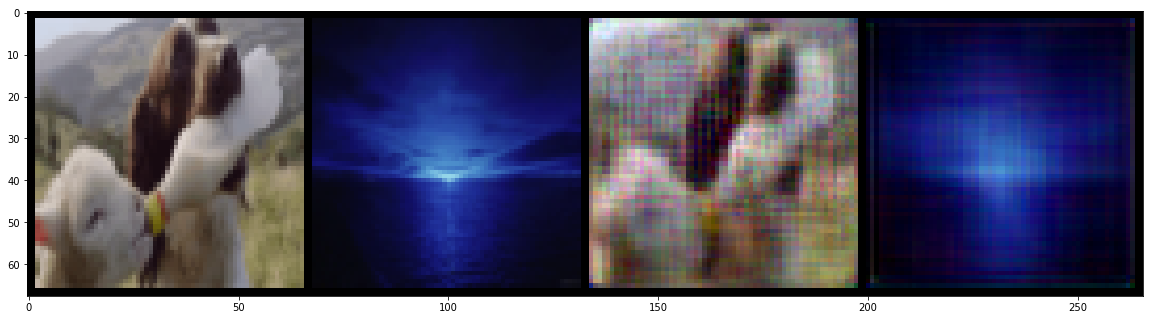

In [42]:
def sample(model, seed_frame, gif_length=10):
    curr_h = model.init_hidden(BATCH_SZ)
    curr_x = seed_frame.to(device=device, dtype=dtype)
    model.eval()
    ret = [seed_frame]
    
    for i in range(gif_length - 1):
        y, curr_h = model(curr_x, curr_h)
        curr_x = y   # TODO: maybe sample from probability?
        ret.append(y.to(device = torch.device('cpu')))
        
    
    return torch.stack(ret).transpose(0, 1)


plt.figure(figsize=(20,40))

    
def test_autoenc(model, loader):
    model.eval()
    dataiter = iter(loader)
    x = dataiter.next()
    
    x = x[:, 0, :, :, :]

    x = x.to(device=device, dtype=dtype)

    
    
    y, mu, logvar = model(x)
    
    x = x.to(torch.device('cpu')).detach()
    y = torch.clamp(y.to(torch.device('cpu')).detach(), 0, 1)
#     y = deprocess(y.to(torch.device('cpu')).detach())
    
    
    imgs = torch.cat([x, y])
    

#     plt.subplot(211)
#     imshow(torchvision.utils.make_grid(x)) #, save_file='img/train_test_orig.png')
#     plt.subplot(212)
    
#     imshow(torchvision.utils.make_grid(y)) #, save_file='img/train_test_out.png')
    imshow(torchvision.utils.make_grid(imgs)) #, save_file='img/train_test_out.png')
    
    
    
    
    

test_autoenc(net, overfit_train_set)